### Processing SRT file

In [6]:
import pandas as pd
import os
import pyarrow.parquet as pq

In [11]:
import os
import re
import pandas as pd

def is_chinese(text):
    """
    Checks if the text contains any Chinese characters.

    Args:
        text (str): Text to check.

    Returns:
        bool: True if Chinese characters are found, False otherwise.
    """
    return bool(re.search(r'[\u4e00-\u9fff]', text))

def is_english(text):
    """
    Checks if the text contains predominantly English characters.

    Args:
        text (str): Text to check.

    Returns:
        bool: True if mostly English characters are found, False otherwise.
    """
    # This regex checks for the presence of English letters and common punctuation.
    return bool(re.fullmatch(r'[A-Za-z0-9\s.,!?:\'\"-]*', text))

def parse_srt(file_path):
    """
    Parses an SRT file and extracts subtitle information.

    Args:
        file_path (str): Path to the SRT file.

    Returns:
        pd.DataFrame: DataFrame containing chinese, and english columns.
    """
    try:
        with open(file_path, 'r', encoding='utf-8-sig') as f:
            content = f.read()
    except UnicodeDecodeError as e:
        print(f"Encoding error in file {file_path}: {e}")
        return pd.DataFrame()  # Return empty DataFrame on error

    # Split the content into blocks separated by two newlines
    blocks = content.strip().split('\n\n')
    data = []

    for block in blocks:
        lines = block.strip().split('\n')

        # Ensure the block has at least 4 lines: index, time, chinese, english
        if len(lines) >= 4:
            try:
                chinese = lines[2].strip()
                english = lines[3].strip()
                
                # Language Checks
                chinese_valid = is_chinese(chinese)
                english_valid = is_english(english)
                
                
                # skip blocks where language checks fail
                if not (chinese_valid and english_valid):
                    print(f"Skipping block due to language mismatch:\n{block}")
                    continue
                
                data.append({
                    'chinese': chinese,
                    'english': english
                })
            except ValueError as ve:
                print(f"Value error parsing block:\n{block}\nError: {ve}")
            except Exception as e:
                print(f"Unexpected error parsing block:\n{block}\nError: {e}")
        else:
            print(f"Skipping incomplete block:\n{block}")

    return pd.DataFrame(data)

def srt_to_parquet(srt_file, parquet_file):
    """
    Converts an SRT file to a Parquet file with matching Chinese and English subtitles.

    Args:
        srt_file (str): Path to the input SRT file.
        parquet_file (str): Path to the output Parquet file.
    """
    df = parse_srt(srt_file)
    if not df.empty:
        try:
            df.to_parquet(parquet_file, index=False)
            print(f"Successfully converted {srt_file} to {parquet_file}")
        except Exception as e:
            print(f"Error saving Parquet file {parquet_file}: {e}")
    else:
        print(f"No data to save for file {srt_file}")


In [19]:
import os

srt_folder = 'subtitle_srt'
target_folder = 'subtitle_parquet'

# Create target folder if it doesn't exist
os.makedirs(target_folder, exist_ok=True)

# Process all .srt files in the srt_folder
for file in os.listdir(srt_folder):
    if file.endswith(".srt"):
        print(f"Processing {file}")
        srt_file = os.path.join(srt_folder, file)
        parquet_file = os.path.join(target_folder, file.replace('.srt', '.parquet'))
        try:
            srt_to_parquet(srt_file, parquet_file)
        except Exception as e:
            print(f"Error processing {srt_file}: {e}")



Processing 1663722269988.srt
Skipping block due to language mismatch:
85
00:09:03,000 --> 00:09:04,990
- 多少钱?  - 两千五百
- How much? - $2,500.
Skipping incomplete block:
330
00:40:20,570 --> 00:40:29,570
[期限: 1994年5月1日]
Skipping incomplete block:
425
00:53:09,770 --> 00:53:12,240
[你的位置被取消]
Skipping incomplete block:
426
00:53:12,410 --> 00:53:14,340
[把钥匙还给你]
Skipping block due to language mismatch:
759
01:29:13,740 --> 01:29:17,040
半个钟头后  我又换了十块钱零钱
Half an hour later, I broke another $10 bill.
Skipping block due to language mismatch:
803
01:32:52,990 --> 01:32:54,960
- 多少钱?  谢谢  - 262元
- How much is it? - $262
Skipping incomplete block:
807
01:34:48,230 --> 01:34:50,220
[经济位  663先生]
Skipping incomplete block:
861
01:39:52,180 --> 01:39:54,610
Written and Directed by
Skipping incomplete block:
862
01:39:54,780 --> 01:39:58,720
WONG KAR-WAI
Skipping incomplete block:
863
01:39:58,890 --> 01:40:01,350
Starring
Skipping incomplete block:
864
01:40:01,520 --> 01:40:04,790
BRIGITTE LIN
Skipping

### Merge all parquet files in target_folder into one parquet file

In [20]:


dfs = []
for file in os.listdir(target_folder):
    if file.endswith(".parquet"):
        file_path = os.path.join(target_folder, file)
        df = pd.read_parquet(file_path)
        dfs.append(df)
        
merged_df = pd.concat(dfs, ignore_index=True)
merged_file = os.path.join('merged_dataSet.parquet')
merged_df.to_parquet(merged_file, index=False)


### Read the merged parquet file and get the first 5 rows

In [21]:
### read the merged parquet file and get the first 5 rows
df = pd.read_parquet(merged_file)
print(f"length of the dataset: {len(df)}")
df.head()



length of the dataset: 13695


,chinese,english
0,每天你都有机会跟别人擦身而过,You brush past so many people every day.
1,你也许对他一无所知,"Some you may never know anything about,"
2,不过也许有一天 他会变成一个朋友或者是知己,but others might become your friend someday.
3,我是一个警察 我的名字叫作何志武,"I'm a cop. My name is He Qiwu,"
4,编号223,and 223 is my badge number.


In [8]:
! pip install nltk

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------- ------------------------------- 0.3/1.5 MB 4.7 MB/s eta 0:00:01
   --------------- ------------------------ 0.6/1.5 MB 5.2 MB/s eta 0:00:01
   ------------------------ --------------- 0.9/1.5 MB 5.8 MB/s eta 0:00:01
   --------------------------------- ------ 1.3/1.5 MB 6.2 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 6.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\CHW\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### EDA

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CHW\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


EDA for Chinese Text


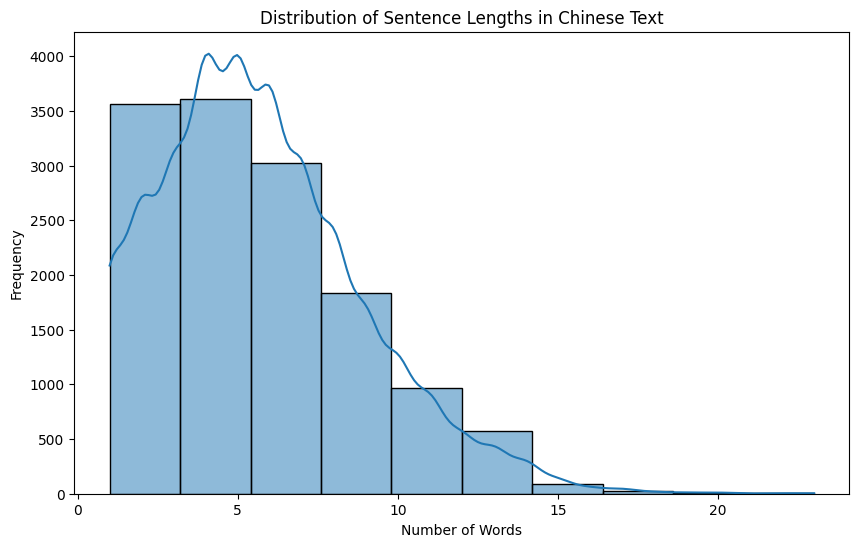

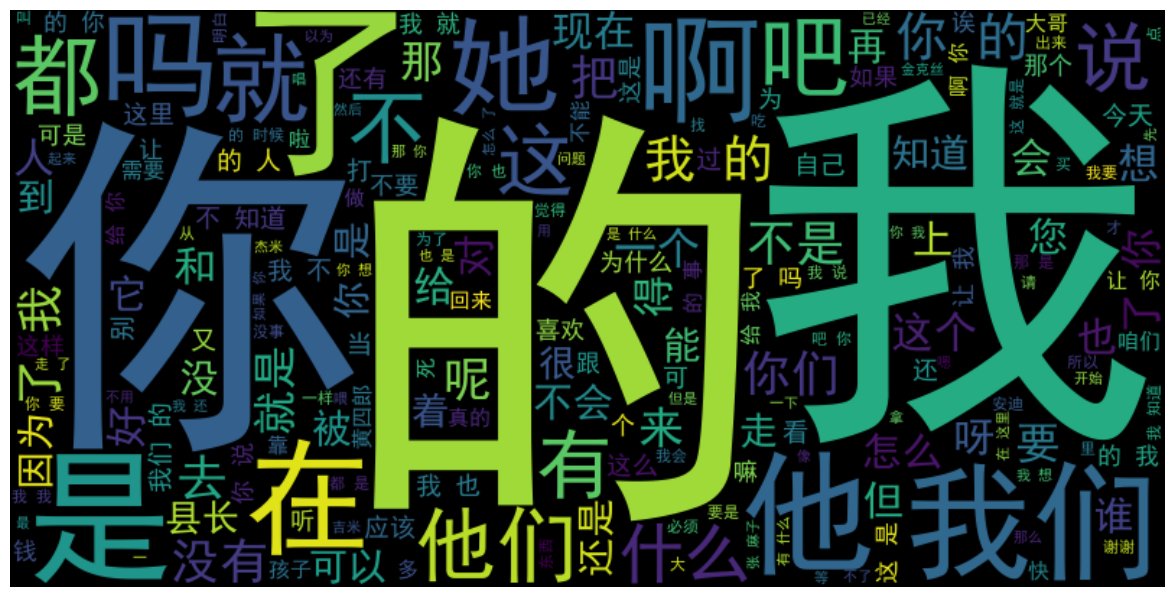

Chinese Statistics:
num_sentences: 13695
num_words: 78182
num_chars: 116350
avg_sentence_length: 5.708798831690398
vocab_size: 10042
most_common_words: [('我', 3095), ('你', 3050), ('的', 3003), ('了', 2242), ('是', 1278), ('不', 709), ('在', 672), ('我们', 670), ('他', 664), ('吗', 644)]
most_common_chars: [('我', 4074), ('你', 3370), ('的', 3173), ('了', 2493), ('是', 2477), ('不', 2400), ('这', 1520), ('们', 1446), ('一', 1443), ('么', 1230)]

EDA for English Text


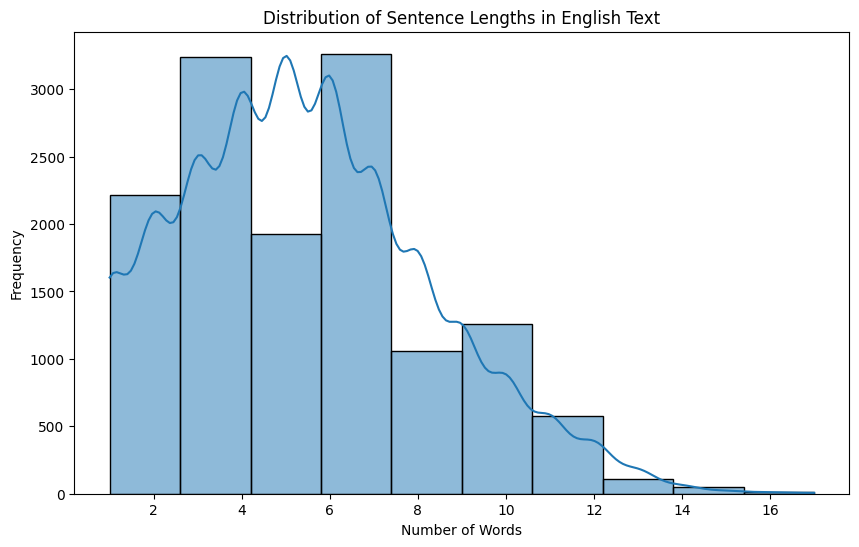

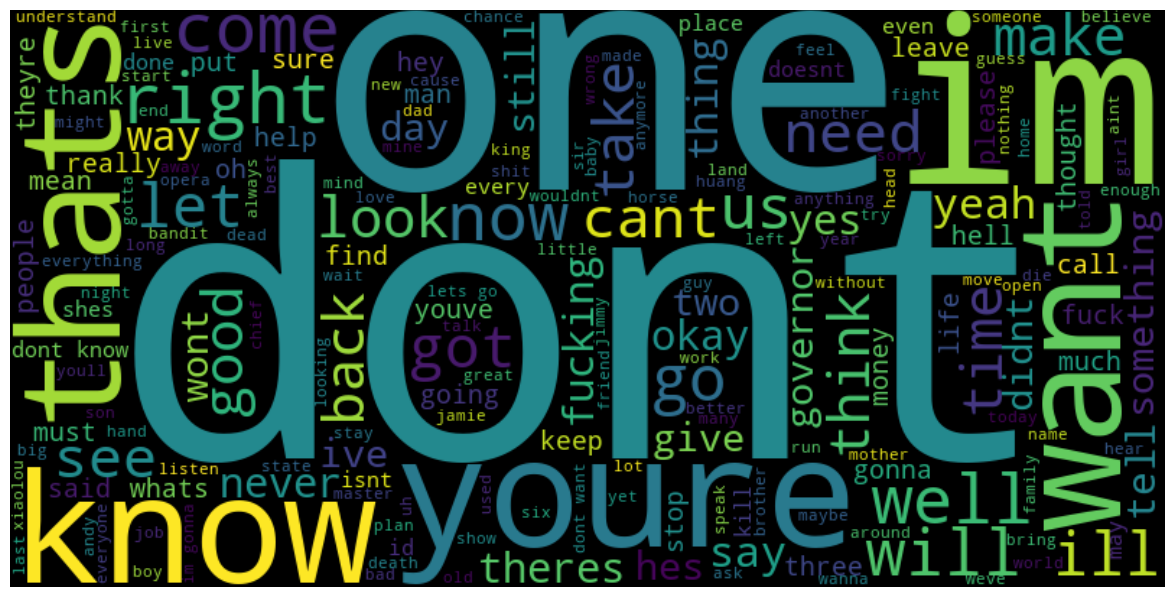

English Statistics:
num_sentences: 13695
num_words: 74646
num_chars: 385934
avg_sentence_length: 5.450602409638554
vocab_size: 6667
most_common_words: [('you', 2914), ('the', 2431), ('i', 2047), ('to', 1926), ('a', 1542), ('it', 1111), ('of', 941), ('and', 922), ('is', 829), ('that', 797)]
most_common_chars: [('e', 34393), ('o', 26620), ('t', 26244), ('a', 21069), ('n', 18947), ('i', 17262), ('s', 16476), ('h', 15997), ('r', 15557), ('u', 11872)]


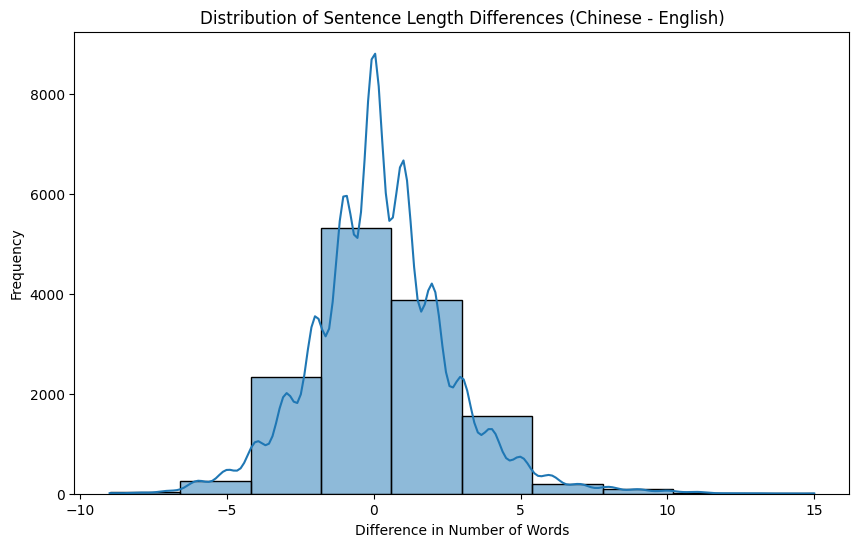

In [19]:
import pandas as pd
import jieba
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns
import nltk
from nltk.util import ngrams
import string

# Ensure you have downloaded the punkt tokenizer
nltk.download('punkt')

# Load Parquet file
def load_parquet(file_path):
    return pd.read_parquet(file_path)

# Chinese text segmentation
def segment_chinese_text(text):
    return list(jieba.cut(text))

# English text preprocessing
def preprocess_english_text(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator).lower().split()

# EDA for Chinese text
def eda_chinese(data, column_name):
    # Segment Chinese text
    data['chinese_words'] = data[column_name].apply(segment_chinese_text)
    
    # Number of sentences
    num_sentences = len(data)
    
    # Flatten list of lists into a single list of words
    all_words = [word for words in data['chinese_words'] for word in words]
    num_words = len(all_words)
    
    # Character count
    num_chars = data[column_name].str.len().sum()
    
    # Average sentence length
    avg_sentence_length = num_words / num_sentences
    
    # Vocabulary size
    vocab_size = len(set(all_words))
    
    # Word frequency
    word_freq = Counter(all_words)
    # Remove the space word
    del word_freq[' ']
    del word_freq['！']
    most_common_words = word_freq.most_common(10)
    
    # Character frequency
    char_freq = Counter(''.join(data[column_name]))
    # remove the space character
    del char_freq[' ']
    most_common_chars = char_freq.most_common(10)
    
    # Sentence length distribution
    sentence_lengths = data['chinese_words'].apply(len)
    
    # Visualization of sentence lengths
    plt.figure(figsize=(10, 6))
    sns.histplot(sentence_lengths, bins=10, kde=True)
    plt.title('Distribution of Sentence Lengths in Chinese Text')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()
    
    # Word Cloud
    wordcloud = WordCloud(font_path='SimHei.ttf', width=800, height=400).generate(' '.join(all_words))
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    # N-gram analysis (bigrams)
    bigrams = list(ngrams(all_words, 2))
    bigram_freq = Counter(bigrams)
    most_common_bigrams = bigram_freq.most_common(10)
    
    stats = {
        'num_sentences': num_sentences,
        'num_words': num_words,
        'num_chars': num_chars,
        'avg_sentence_length': avg_sentence_length,
        'vocab_size': vocab_size,
        'most_common_words': most_common_words,
        'most_common_chars': most_common_chars,
        'sentence_lengths': sentence_lengths,
        'most_common_bigrams': most_common_bigrams
    }
    return stats

# EDA for English text
def eda_english(data, column_name):
    # Preprocess English text
    data['english_words'] = data[column_name].apply(preprocess_english_text)
    
    # Number of sentences
    num_sentences = len(data)
    
    # Flatten list of lists into a single list of words
    all_words = [word for words in data['english_words'] for word in words]
    num_words = len(all_words)
    
    # Character count
    num_chars = data[column_name].str.len().sum()
    
    # Average sentence length
    avg_sentence_length = num_words / num_sentences
    
    # Vocabulary size
    vocab_size = len(set(all_words))
    
    # Word frequency
    word_freq = Counter(all_words)
    del word_freq[' ']
    most_common_words = word_freq.most_common(10)
    
    # Character frequency
    char_freq = Counter(''.join(data[column_name]))
    del char_freq[' ']
    most_common_chars = char_freq.most_common(10)
    
    # Sentence length distribution
    sentence_lengths = data['english_words'].apply(len)
    
    # Visualization of sentence lengths
    plt.figure(figsize=(10, 6))
    sns.histplot(sentence_lengths, bins=10, kde=True)
    plt.title('Distribution of Sentence Lengths in English Text')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()
    
    # Word Cloud
    wordcloud = WordCloud(width=800, height=400).generate(' '.join(all_words))
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    # N-gram analysis (bigrams)
    bigrams = list(ngrams(all_words, 2))
    bigram_freq = Counter(bigrams)
    most_common_bigrams = bigram_freq.most_common(10)
    
    stats = {
        'num_sentences': num_sentences,
        'num_words': num_words,
        'num_chars': num_chars,
        'avg_sentence_length': avg_sentence_length,
        'vocab_size': vocab_size,
        'most_common_words': most_common_words,
        'most_common_chars': most_common_chars,
        'sentence_lengths': sentence_lengths,
        'most_common_bigrams': most_common_bigrams
    }
    return stats

# Perform EDA
def perform_eda(file_path):
    # Load the data
    data = load_parquet(file_path)
    
    # EDA for Chinese text
    print("EDA for Chinese Text")
    chinese_stats = eda_chinese(data, 'chinese')
    print("Chinese Statistics:")
    for key, value in chinese_stats.items():
        if key not in ['sentence_lengths', 'most_common_bigrams']:
            print(f"{key}: {value}")
    
    # EDA for English text
    print("\nEDA for English Text")
    english_stats = eda_english(data, 'english')
    print("English Statistics:")
    for key, value in english_stats.items():
        if key not in ['sentence_lengths', 'most_common_bigrams']:
            print(f"{key}: {value}")
    
    # Bilingual comparison
    data['chinese_sentence_length'] = data['chinese_words'].apply(len)
    data['english_sentence_length'] = data['english_words'].apply(len)
    data['length_difference'] = data['chinese_sentence_length'] - data['english_sentence_length']
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data['length_difference'], bins=10, kde=True)
    plt.title('Distribution of Sentence Length Differences (Chinese - English)')
    plt.xlabel('Difference in Number of Words')
    plt.ylabel('Frequency')
    plt.show()
    
    return chinese_stats, english_stats

# Sample usage
file_path = "merged_dataSet.parquet"  # Replace with the actual file path
chinese_stats, english_stats = perform_eda(file_path)
